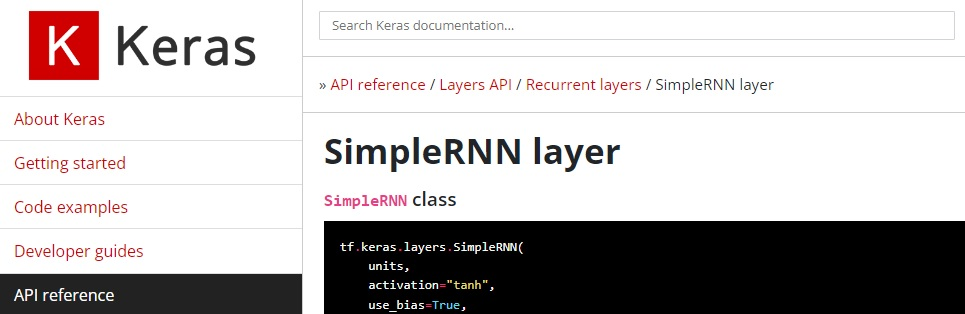

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import History
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from utils import *

np.set_printoptions(suppress=True)

In [2]:
vendas = pd.read_excel('./vendas_v3.xlsx')
vendas.sort_values(by=['data_venda'], ascending=True)

vendas_por_dia = vendas.copy()
vendas_por_dia = vendas_por_dia[['data_venda', 'valor']]
data = vendas_por_dia.groupby(by=['data_venda']).sum()

data = data.to_numpy()
data.shape

(341, 1)

In [3]:
#data, _mean, _std = zscore(data)
scaler = MinMaxScaler()
scaler.fit(data)

data = scaler.transform(data)
data

array([[0.08877362],
       [0.07466257],
       [0.0857037 ],
       [0.07666331],
       [0.07651511],
       [0.00746308],
       [0.00751601],
       [0.00934738],
       [0.0134653 ],
       [0.00753718],
       [0.00130207],
       [0.01191976],
       [0.00555761],
       [0.011888  ],
       [0.00593871],
       [0.00047637],
       [0.01986979],
       [0.00455195],
       [0.00122797],
       [0.00931562],
       [0.01033187],
       [0.        ],
       [0.00863812],
       [0.01250198],
       [0.0048907 ],
       [0.01070238],
       [0.00817234],
       [0.01579421],
       [0.00608691],
       [0.00744191],
       [0.00442492],
       [0.09528397],
       [0.09833272],
       [0.10439845],
       [0.10784947],
       [0.11261314],
       [0.03292225],
       [0.02075901],
       [0.02136241],
       [0.03681787],
       [0.01695866],
       [0.01757265],
       [0.01709628],
       [0.03036045],
       [0.03490182],
       [0.02557561],
       [0.02965119],
       [0.032

In [4]:
data = data.reshape(data.shape[0])
data.shape

(341,)

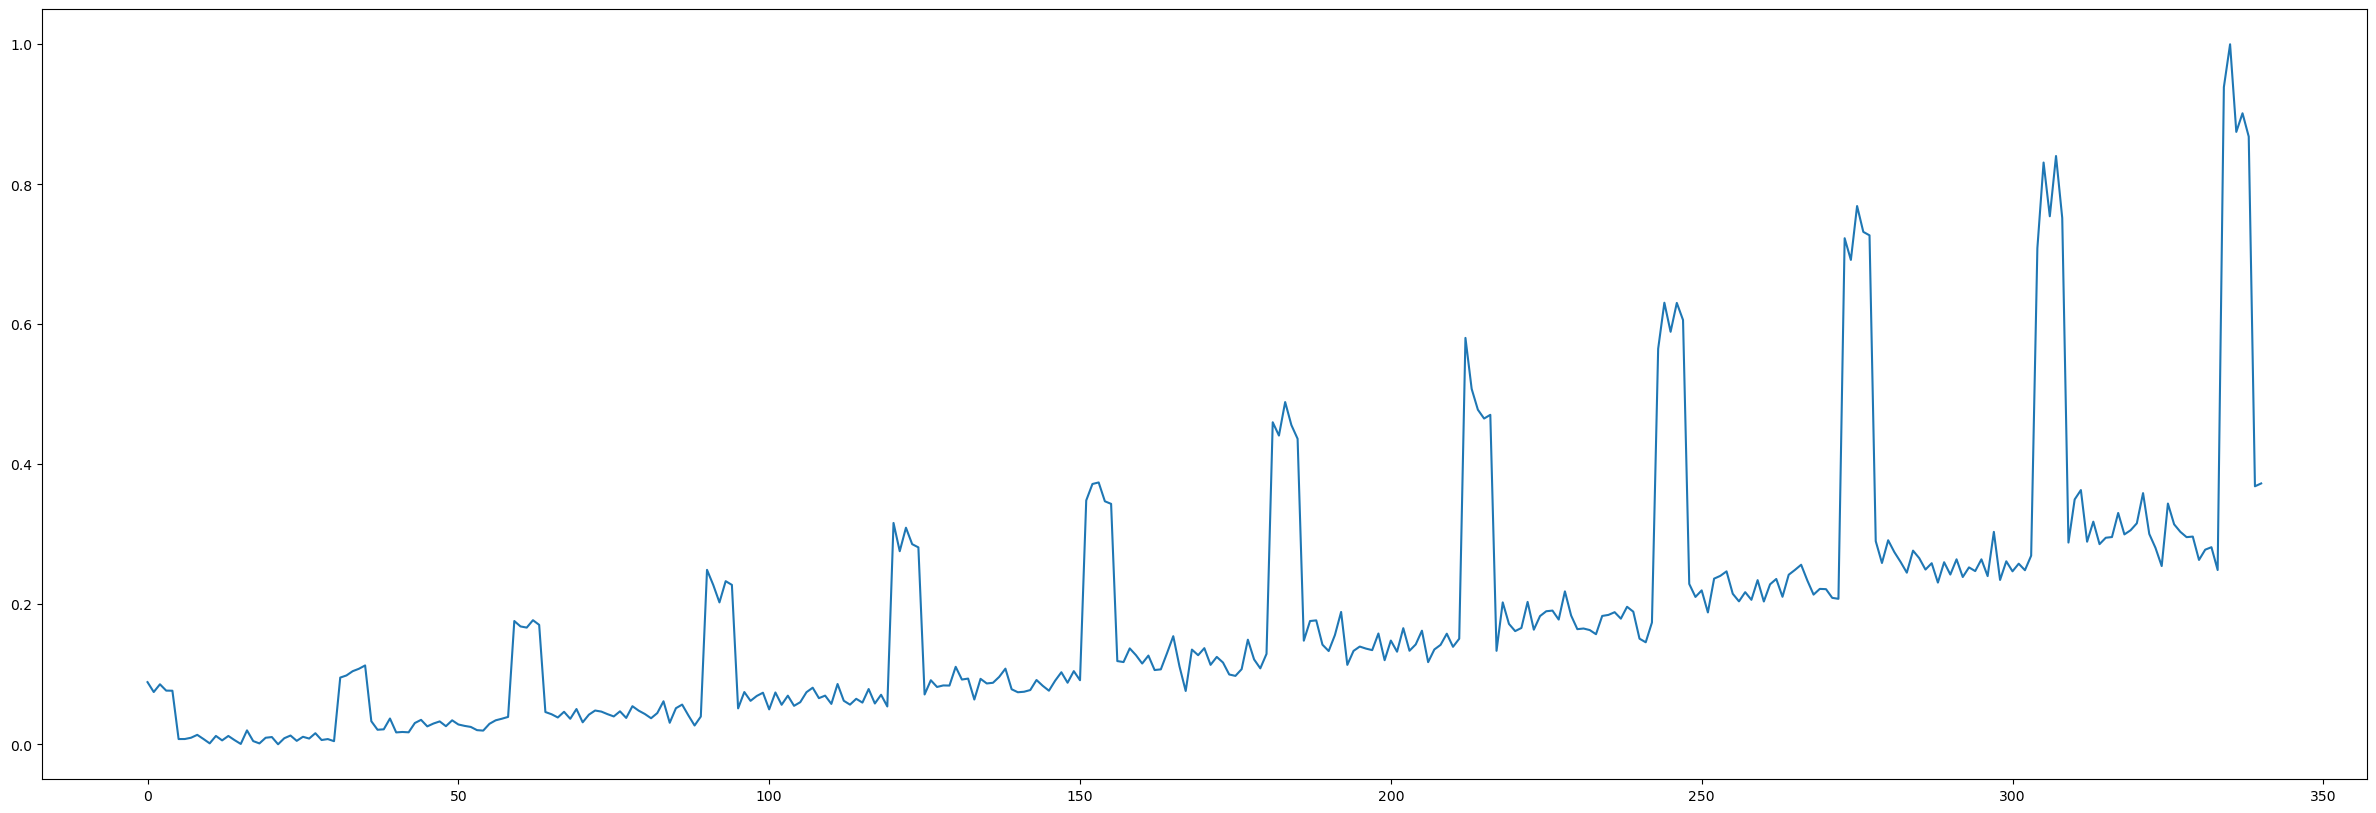

In [5]:
plt.figure(figsize=(30, 10))
plt.plot(data)

In [6]:
train_size = int(data.shape[0] * .5)

train = data[:train_size]
test = data[train_size:]

train.shape, test.shape

((170,), (171,))

In [7]:
step = 60
x_train, y_train = convertToMatrix(train, step)
x_test, y_test = convertToMatrix(test, step)

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
x_train.shape

(110, 1, 60)

In [8]:
x_train[:2]

array([[[0.08877362, 0.07466257, 0.0857037 , 0.07666331, 0.07651511,
         0.00746308, 0.00751601, 0.00934738, 0.0134653 , 0.00753718,
         0.00130207, 0.01191976, 0.00555761, 0.011888  , 0.00593871,
         0.00047637, 0.01986979, 0.00455195, 0.00122797, 0.00931562,
         0.01033187, 0.        , 0.00863812, 0.01250198, 0.0048907 ,
         0.01070238, 0.00817234, 0.01579421, 0.00608691, 0.00744191,
         0.00442492, 0.09528397, 0.09833272, 0.10439845, 0.10784947,
         0.11261314, 0.03292225, 0.02075901, 0.02136241, 0.03681787,
         0.01695866, 0.01757265, 0.01709628, 0.03036045, 0.03490182,
         0.02557561, 0.02965119, 0.03266818, 0.02582967, 0.03424549,
         0.02828561, 0.02628487, 0.02478167, 0.02019796, 0.01953104,
         0.02922776, 0.03422432, 0.03651088, 0.03908326, 0.17608638]],

       [[0.07466257, 0.0857037 , 0.07666331, 0.07651511, 0.00746308,
         0.00751601, 0.00934738, 0.0134653 , 0.00753718, 0.00130207,
         0.01191976, 0.00555761

In [9]:
model = Sequential()

##model.add(BatchNormalization(input_shape=(1, step)))

model.add(SimpleRNN(units=32, input_shape=(1, step), activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1))

opt = Adam(learning_rate=0.0002)

model.compile(
    optimizer=opt,
    loss='mean_squared_error',
    metrics=['MSE']
)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                2976      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5121 (20.00 KB)
Trainable params: 5121 (2

In [10]:
loss_history = History()

model.fit(
    x_train,
    y_train,
    epochs=2000,
    batch_size=32,
    verbose=1,
    validation_data=(
        x_test,
        y_test
    ),
    callbacks=[loss_history]
)

trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

predicted = np.concatenate((trainPredict, testPredict), axis=0)

trainScore = model.evaluate(x_test, y_test, verbose=0)
print(trainScore)

Epoch 1/2000


4/4 [==============================] - 2s 108ms/step - loss: 0.0175 - MSE: 0.0175 - val_loss: 0.0912 - val_MSE: 0.0912
Epoch 2/2000
4/4 [==============================] - 0s 15ms/step - loss: 0.0154 - MSE: 0.0154 - val_loss: 0.0743 - val_MSE: 0.0743
Epoch 3/2000
4/4 [==============================] - 0s 15ms/step - loss: 0.0160 - MSE: 0.0160 - val_loss: 0.0619 - val_MSE: 0.0619
Epoch 4/2000
4/4 [==============================] - 0s 18ms/step - loss: 0.0173 - MSE: 0.0173 - val_loss: 0.0525 - val_MSE: 0.0525
Epoch 5/2000
4/4 [==============================] - 0s 14ms/step - loss: 0.0129 - MSE: 0.0129 - val_loss: 0.0463 - val_MSE: 0.0463
Epoch 6/2000
4/4 [==============================] - 0s 14ms/step - loss: 0.0135 - MSE: 0.0135 - val_loss: 0.0426 - val_MSE: 0.0426
Epoch 7/2000
4/4 [==============================] - 0s 13ms/step - loss: 0.0143 - MSE: 0.0143 - val_loss: 0.0406 - val_MSE: 0.0406
Epoch 8/2000
4/4 [==============================] - 0s 12ms/step - loss: 0.0111 

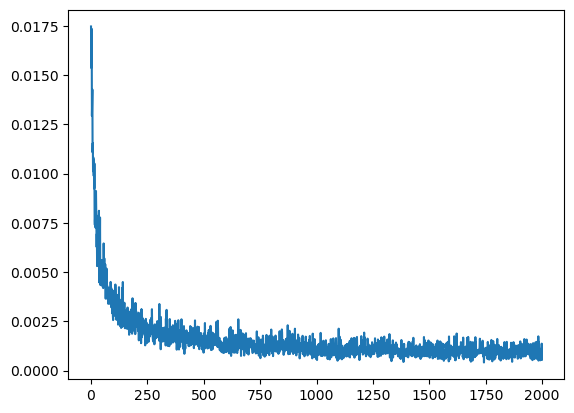

In [11]:
plt.plot(loss_history.history['loss'])

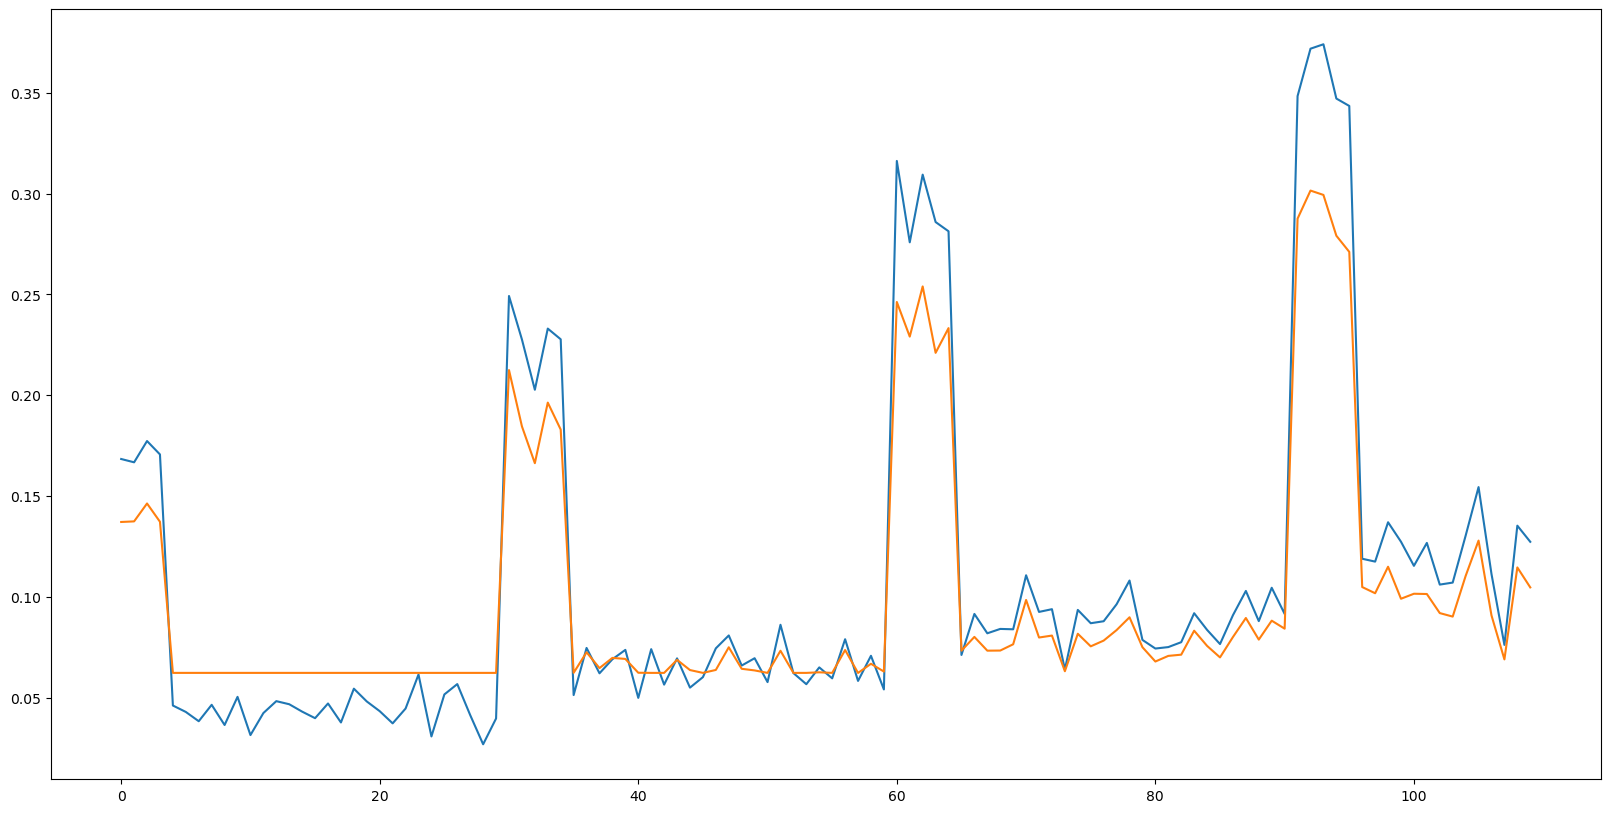

In [12]:
plt.figure(figsize=(20, 10))
plt.plot(y_train)
plt.plot(trainPredict)

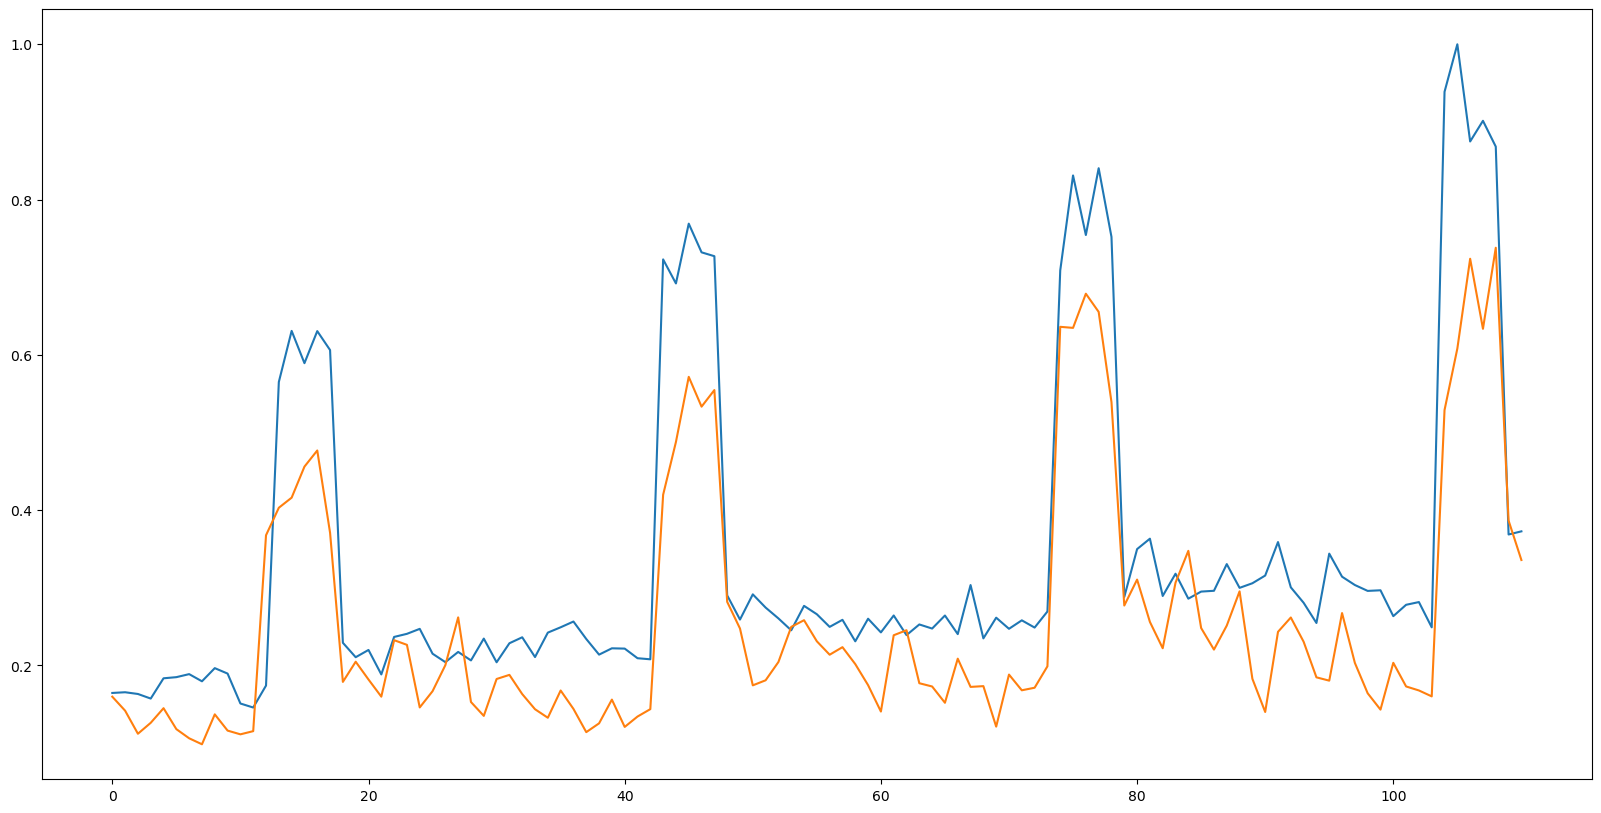

In [13]:
plt.figure(figsize=(20, 10))
plt.plot(y_test)
plt.plot(testPredict)


In [16]:
model.save('Modelo_APS_GastronomIA.h5', save_format='h5')